In [ ]:
!pip install pandas-datareader
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import kstest
import statsmodels.api as sm
from scipy.stats import norm
import scipy.stats as stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  9 of 9 completed


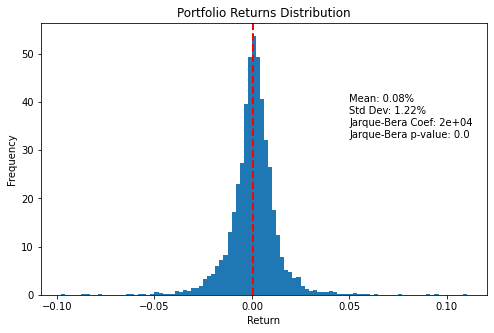

In [ ]:
symbols = ['AAPL', 'AMZN', 'GOOG', 'PG', 'MA', 'V', 'JNJ', 'WMT', 'MCD']

# Download the adjusted close prices for the stocks in the portfolio
prices = yf.download(symbols, start='2000-01-01', end='2023-02-17')['Adj Close']

# Calculate the daily returns
returns = prices.pct_change().dropna()

# Define the weights for the portfolio
w = 1/9
weights = np.array([w, w, w, w, w, w, w, w, w])

# Calculate the mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Set the confidence level and investment amount
conf_level = 0.95

# Calculate the portfolio return and volatility
portfolio_return = np.dot(weights, mean_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

jb = stats.jarque_bera(returns.dot(weights))

# Plot the distribution of the portfolio returns
plt.figure(figsize=(8, 5))
plt.hist(returns.dot(weights), bins=100, density=True)
plt.axvline(portfolio_return, color='r', linestyle='dashed', linewidth=2)
plt.text(0.05, 40, 'Mean: {:.2f}%'.format(portfolio_return*100))
plt.text(0.05, 37.5, 'Std Dev: {:.2f}%'.format(np.std(returns.dot(weights))*100))
plt.text(0.05, 35, 'Jarque-Bera Coef: {:.0}'.format(jb[0]))
plt.text(0.05, 32.5,  'Jarque-Bera p-value: {:}'.format(jb[1]))
plt.title('Portfolio Returns Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()



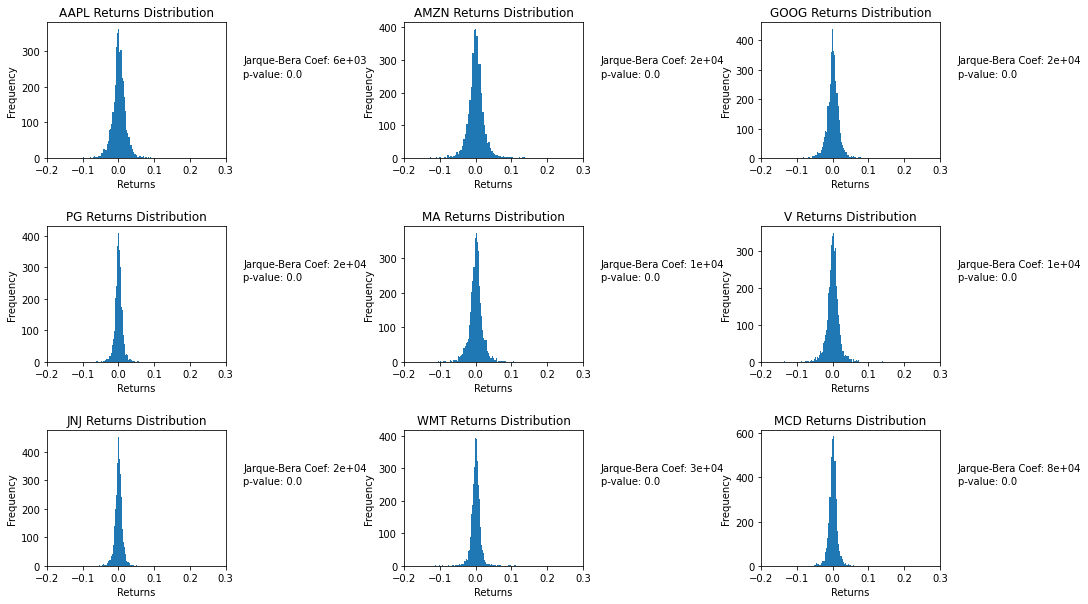

In [ ]:
#Histograms

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
fig.subplots_adjust(hspace=0.5, wspace=1)

for i, symbol in enumerate(symbols):
    row = i // 3
    col = i % 3
    stock_returns = returns[symbol]
    ax = axes[row, col]
    ax.hist(stock_returns, bins=100)
    ax.set_title('{} Returns Distribution'.format(symbol))
    ax.set_xlabel('Returns')
    ax.set_ylabel('Frequency')
    jb = stats.jarque_bera(stock_returns)
    ax.text(1.1, 0.7, 'Jarque-Bera Coef: {:.0}'.format(jb[0]), transform=ax.transAxes)
    ax.text(1.1, 0.6,  'p-value: {:}'.format(jb[1]), transform=ax.transAxes)
    ax.set_xlim(-0.2, 0.3)
    ax.margins(x=0.3)
    
plt.show()

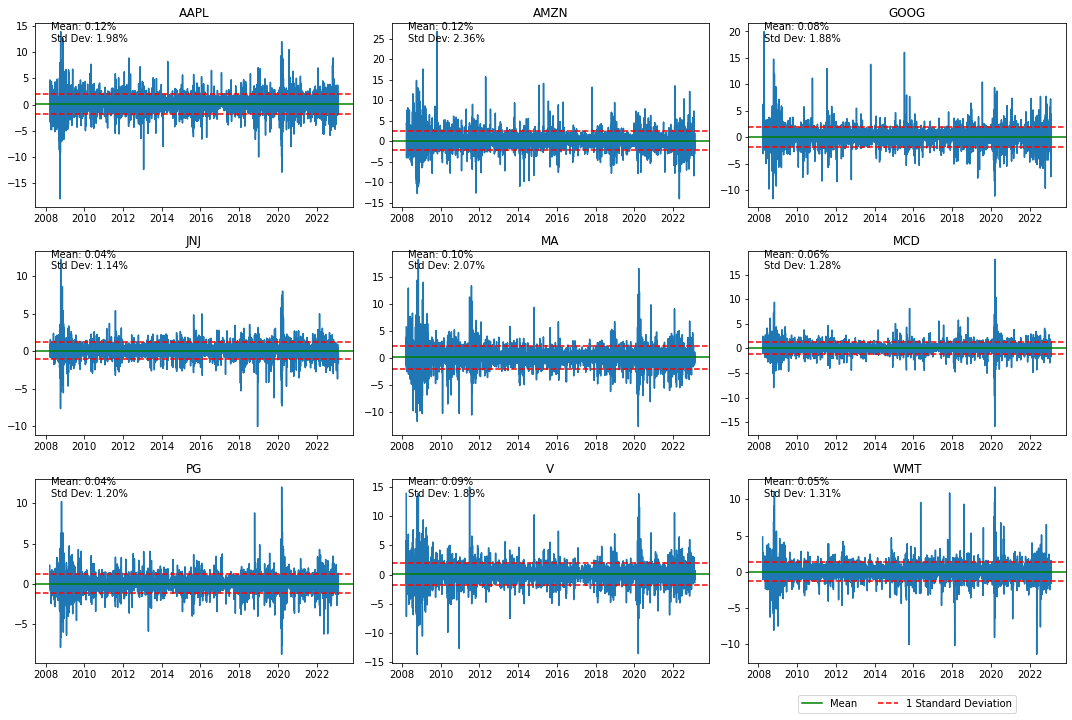

In [ ]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Iterate over the columns and add each stock's returns to a subplot
for i, column in enumerate(returns.columns):
    # Add the column data to the current subplot
    axes[i].plot(returns[column]*100)
    
    # Compute the mean and standard deviation for the current stock
    mean = returns[column].mean()*100
    std_dev = returns[column].std()*100
    
    # Add the mean and standard deviation as annotations to the plot
    axes[i].axhline(y=mean, color='green', label='Mean')
    axes[i].axhline(y=mean+std_dev, linestyle='--', color='red', label='1 Standard Deviation')
    axes[i].axhline(y=mean-std_dev, linestyle='--', color='red')
    axes[i].annotate(f'Mean: {mean:.2f}%\nStd Dev: {std_dev:.2f}%', xy=(0.05, 0.9), xycoords='axes fraction')

    # Set the title of the subplot to the column name
    axes[i].set_title(column)

# Move the legends to the bottom center of the figure
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the figure
plt.show()


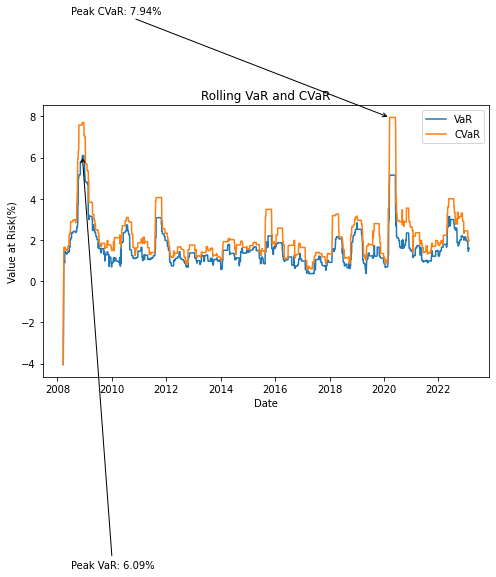

In [ ]:
# Define the rolling window size
rolling_window = 60

# Calculate the rolling VaR and CVaR, ignoring NaN values
rolling_var = returns.dot(weights).rolling(window=rolling_window, min_periods=1).apply(lambda x: np.percentile(x, q=100-conf_level*100))
rolling_cvar = returns.dot(weights).rolling(window=rolling_window, min_periods=1).apply(lambda x: x[x <= np.percentile(x, q=100-conf_level*100)].mean())

# Find the peak values of rolling VaR and CVaR, ignoring NaN values
peak_var = -rolling_var.min(skipna=True)
peak_cvar = -rolling_cvar.min(skipna=True)



fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rolling_var.index, -rolling_var*100, label='VaR')
ax.plot(rolling_cvar.index, -rolling_cvar*100, label='CVaR')
ax.set_xlabel('Date')
ax.set_ylabel('Value at Risk(%)')
ax.set_title('Rolling VaR and CVaR')
ax.legend()

# Annotate the peak values, ignoring NaN values
ax.annotate(f"Peak VaR: {peak_var*100:.2f}%", xy=(rolling_var.idxmin(skipna=True), peak_var*100),
            xytext=(rolling_var.idxmax(skipna=True)+pd.Timedelta(days=100), peak_var*100-20),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=10)
ax.annotate(f"Peak CVaR: {peak_cvar*100:.2f}%", xy=(rolling_cvar.idxmin(skipna=True), peak_cvar*100),
            xytext=(rolling_cvar.idxmax(skipna=True)+pd.Timedelta(days=100), peak_cvar*100+5),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=10)

# Show the plot
plt.show()


In [ ]:
rolling_var_sorted = -rolling_var.sort_values(ascending=True)
rolling_var_sorted[0:60]

Date
2008-12-18    0.060938
2008-12-22    0.060938
2008-12-19    0.060938
2008-12-17    0.060938
2008-12-16    0.060938
2008-12-15    0.060938
2008-12-12    0.060938
2008-12-11    0.060938
2008-12-10    0.060938
2008-12-09    0.060938
2008-12-08    0.060938
2008-12-05    0.060938
2008-12-04    0.060938
2008-12-03    0.060938
2008-12-01    0.060938
2008-12-02    0.060938
2008-11-28    0.058048
2008-12-29    0.058048
2008-12-26    0.058048
2008-12-24    0.058048
2008-12-23    0.058048
2008-11-05    0.058048
2008-11-06    0.058048
2008-11-07    0.058048
2008-11-10    0.058048
2008-11-11    0.058048
2008-11-12    0.058048
2008-11-13    0.058048
2008-11-14    0.058048
2008-11-17    0.058048
2008-11-18    0.058048
2008-11-19    0.058048
2008-11-20    0.058048
2008-11-21    0.058048
2008-12-30    0.058048
2008-11-24    0.058048
2008-11-26    0.058048
2008-12-31    0.058048
2008-11-25    0.058048
2008-10-31    0.051612
2008-10-15    0.051612
2008-10-16    0.051612
2008-10-17    0.051612
2008-1

In [ ]:
rolling_cvar_sorted = -rolling_cvar.sort_values(ascending=True)
rolling_cvar_sorted[0:60]

Date
2020-03-18    0.079441
2020-05-01    0.079441
2020-04-30    0.079441
2020-04-29    0.079441
2020-04-28    0.079441
2020-04-27    0.079441
2020-04-24    0.079441
2020-05-04    0.079441
2020-04-23    0.079441
2020-04-21    0.079441
2020-04-20    0.079441
2020-04-17    0.079441
2020-04-16    0.079441
2020-04-15    0.079441
2020-04-14    0.079441
2020-04-22    0.079441
2020-04-13    0.079441
2020-05-05    0.079441
2020-05-07    0.079441
2020-05-28    0.079441
2020-05-27    0.079441
2020-05-26    0.079441
2020-05-22    0.079441
2020-05-21    0.079441
2020-05-20    0.079441
2020-05-06    0.079441
2020-05-19    0.079441
2020-05-15    0.079441
2020-05-14    0.079441
2020-05-13    0.079441
2020-05-12    0.079441
2020-05-11    0.079441
2020-05-08    0.079441
2020-05-18    0.079441
2020-05-29    0.079441
2020-06-01    0.079441
2020-03-26    0.079441
2020-04-02    0.079441
2020-04-01    0.079441
2020-04-07    0.079441
2020-04-08    0.079441
2020-04-09    0.079441
2020-03-31    0.079441
2020-0

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rolling_var.index, -rolling_var*100, label='VaR')
ax.plot(rolling_cvar.index, -rolling_cvar*100, label='CVaR')
ax.set_xlabel('Date')
ax.set_ylabel('Value at Risk(%)')
ax.set_title('Rolling VaR and CVaR')
ax.legend()

-0.04044294671690658

In [ ]:
-100*rolling_cvar.max()

0.579509775492503

In [ ]:
print(max(np.array(rolling_var)))
print(max(np.array(rolling_cvar)))
type(rolling_var)

nan
nan


pandas.core.series.Series

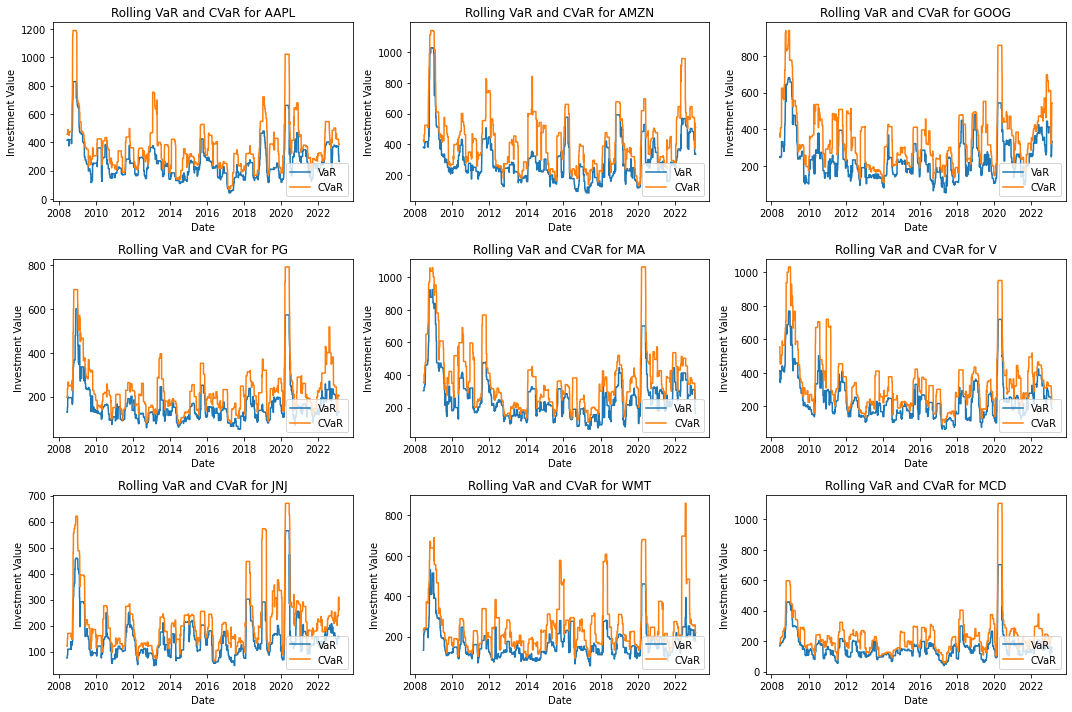

In [ ]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Iterate over the symbols and add each stock's VaR and CVaR to a subplot
for i, symbol in enumerate(symbols):
    # Select the returns for the current stock
    stock_returns = returns[symbol]

    # Calculate the rolling VaR and CVaR
    rolling_var = stock_returns.rolling(window=rolling_window).apply(lambda x: np.percentile(x, q=100-conf_level*100))
    rolling_cvar = stock_returns.rolling(window=rolling_window).apply(lambda x: x[x <= np.percentile(x, q=100-conf_level*100)].mean())

    # Add the rolling VaR and CVaR to the current subplot
    axes[i].plot(rolling_var.index, -rolling_var*investment, label='VaR')
    axes[i].plot(rolling_cvar.index, -rolling_cvar*investment, label='CVaR')
    
    # Set the title and axis labels for the current subplot
    axes[i].set_title(f"Rolling VaR and CVaR for {symbol}")
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Investment Value')

    # Invert the y-axis and set the legend
    axes[i].legend(loc='lower right')

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the figure
plt.show()

